In [17]:
import ee 

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

from geeml.utils import eeprint
import geemap
import os
from tqdm.auto import tqdm
import sys
from typing import Union
from geedim.download import BaseImage
from pathlib import Path

In [18]:
# Supported sensors and radiometric corrections 
supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

def preprocessOptical(image, sensor):
    """Select Bands and scale between 0 and 1
    """
    bandSelect = {'Sentinel-2': 'B.*',
                    'LANDSAT_8': 'SR_B.',
                    'LANDSAT_9': 'SR_B.'}
    # Step 2) radiometric correction
    radiometricMultiplySelect = {'Sentinel-2': 0.0001,
                    'LANDSAT_8': 0.0000275,
                    'LANDSAT_9': 0.0000275}
    radiometricAddSelect = {'Sentinel-2': 0,
                    'LANDSAT_8': -0.2,
                    'LANDSAT_9': -0.2}
    
    # Step 3) depending on image selected, select cloud band
    return image.select(bandSelect.get(sensor)).multiply(radiometricMultiplySelect.get(sensor)).add(radiometricAddSelect.get(sensor)).copyProperties(image)


In [3]:
startDate = ee.Date('2017-03-28')# date for s2
startDate = ee.Date('2013-02-11')# date for l8
mtbs = ee.FeatureCollection("USFS/GTAC/MTBS/burned_area_boundaries/v1")\
    .filter(ee.Filter.gte('Ig_Date', startDate.millis()))
mtbs_sz = mtbs.size().getInfo()
print(mtbs_sz)
mtbs_list = mtbs.toList(mtbs_sz)

9399


In [4]:
eeprint(mtbs.first())

## Landsat data extraction

In [7]:
# Landsat data exploration
def cloudMask1(image):
    clouds = image.select('QA_PIXEL').bitwiseAnd(0b1000).eq(0)
    cirrus = image.select('QA_PIXEL').bitwiseAnd(0b1100).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    #   Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    #  Replace the original bands with the scaled ones and apply the masks.
    return opticalBands\
        .updateMask(clouds)\
        .updateMask(cirrus)\
        .updateMask(saturationMask)

def cloudMask2(image):
    clouds = image.select('QA_PIXEL').bitwiseAnd(0b1000).eq(0)
    cirrus = image.select('QA_PIXEL').bitwiseAnd(0b1100).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    #   Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Compute normalised burn ratio (NBR)
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('nbr')

    #  Replace the original bands with the scaled ones and apply the masks.
    return opticalBands.addBands([nbr], None, True)\
        .updateMask(clouds)\
        .updateMask(cirrus)\
        .updateMask(saturationMask)
def qualityMosaicPercentile(collection, QAband, percentile):
    # Compute percentile image
    percentileImage = collection.select(QAband).reduce(ee.Reducer.percentile([percentile]))
    #  Compute distance of every pixel from the computed percentile in that location
    withDist = ee.ImageCollection(collection.map(lambda image: image.addBands([
        image.select(QAband).subtract(percentileImage).abs().multiply(-1).rename('quality')])))
    return withDist.qualityMosaic('quality')

In [9]:
event = mtbs.first()
# Given a fire event get pre and post fire image from single sensor 
eventDate = ee.Date(event.getNumber('Ig_Date'))
print('event Date:', eventDate.format().getInfo())
dateBuffer = 10
# get first image after fire
startDate = eventDate#.advance(1, 'week')
endDate = eventDate.advance(dateBuffer, 'week')
sat_data = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(event.geometry()).filterDate(startDate, endDate)
postFireImg2 = qualityMosaicPercentile(sat_data.map(cloudMask2), 'nbr', 75)
postFireImg1 = sat_data.map(cloudMask1).sort('system:time_start', False).reduce(ee.Reducer.firstNonNull())#.first()

# get first image before fire
startDate = eventDate.advance(dateBuffer*-1, 'week')
endDate = eventDate
preFireImg = sat_data.filterBounds(event.geometry()).filterDate(startDate, endDate).sort('system:time_start', False).first()
# print('preFire Date:', ee.Date(preFireImg.date()).format().getInfo())

# Visualise images
Map = geemap.Map()
Map.addLayer(postFireImg2.select('SR_B.*'), {'min':0, 'max':0.7, 'bands': ['SR_B7', 'SR_B5', 'SR_B4']}, 'Post2')

Map.addLayer(postFireImg1.select('SR_B.*').multiply(0.0000275).add(-0.2), {'min':0, 'max':0.7, 'bands': ['SR_B7_first', 'SR_B5_first', 'SR_B4_first']}, 'Post1')
# Map.addLayer(preFireImg.select('SR_B.').multiply(0.0000275).add(-0.2), {'min':0, 'max':0.7, 'bands': ['SR_B7', 'SR_B5', 'SR_B4']}, 'Pre')

Map.addLayer(event.geometry())
Map.centerObject(event.geometry(), 8)
Map

event Date: 2020-08-02T07:00:00


Map(center=[45.700904791805044, -108.9492538395029], controls=(WidgetControl(options=['position', 'transparent…

In [20]:
def getImage(sensor, pre, event, dateBuffer):
    """
    Get the temporally closest pre-fire and post-fire optical or radar images after preprocessing both
    the optical images.

    Args:
        event (ee.Feature): A fire event delineating the boundary of burnt area
        dateBuffer (int): The temporal window to locate a relevant image. In units of weeks.

    Returns:
        A pre-fire and post-fire optical or radar image
    """
    # Filter images that intersect the geometry using the optimised filterBounds. Thereafter, use the
    # ee.filter.contains that is not as optimised as filterBounds
    images = supportedSensors.get(sensor).filterBounds(event.geometry())
    eventDate = ee.Date(event.get('Ig_Date'))
    if pre:
        startDate = eventDate.advance(dateBuffer*-1, 'week')
        endDate = eventDate
        outImage = images.filterDate(startDate, endDate).sort('system:time_start', False).map(lambda img: cloudMask1(img)).reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', False).first()

    else:
        # postfire
        startDate = eventDate
        endDate = eventDate.advance(dateBuffer, 'week')
        outImage = images.filterDate(startDate, endDate).map(lambda img: cloudMask2(img))#.reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')#.qualityMosaic('nbr')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', True).first()
    
    return outImage

    # Given a fire event get pre and post fire image from multi-sensors
def getOpticalRadarPairs(sensor:str, dnbr:bool, event: ee.Feature, dateBuffer: int = 4)-> ee.Image:
    """
    Get optical-radar pairs for a given fire event. First image after fire event and image before fire event

    Args:
        sensor(str): The name of the sensor. One of ['Sentinel-1', 'Sentinel-2', 'Landsat_8', 'Landsat_9']
        event(ee.Feature): A fire event
        dateBuffer(int): The temporal-search window. 
    
    Returns:
        An image with optical-radar pairs

    """
    # Post-fire image
    postOpticalImage = getImage(sensor, False, event, dateBuffer= dateBuffer)
    # pre-fire
    preOpticalImage = getImage(sensor, True, event, dateBuffer= dateBuffer)

    # if sensor == 'Sentinel-1':
    #     # RADAR
    #     s1post = getImage('Sentinel-1', False, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1post.date().advance(1, 'day'), 'START_DATE': s1post.date(), 'ROI': event.geometry()})
    #     s1post = wp.s1_preproc(parameters).select('V.')
    
    if sensor == 'Sentinel-2':
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['B8A', 'B12']).subtract(img.normalizedDifference(['B8A', 'B12'])).rename('dnbr'))), 'dnbr', 95) 
    if sensor == 'LANDSAT_8' or sensor == 'LANDSAT_9':
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['SR_B5', 'SR_B7']).subtract(img.normalizedDifference(['SR_B5', 'SR_B7'])).rename('dnbr'))), 'dnbr', 95)
    return postOpticalImage
    

In [21]:
def prepareLabel(event: ee.Feature, patchSize: int, scale: int)-> ee.Image:
    """
    Converts a burn area polygon (ee.Feature) to a raster label. Burnt pixels are assigned a value of 1.
    Unburnt pixels are assigned a value of 0. the returned ee.Image dimensions should closely approximate
    the number of pixels divisible by the patchSize.

    Args:
        event(ee.Feature): The delineated burn area polygon to rasterize.
        patchSize (int): The desirable patch dimension when training the DNN model.
        scale (int): The desired output scale for the label.

    Returns:
        The rasterised label (ee.Image)
    """
    # Define the WKT string for EPSG:102005
    wkt = ('PROJCS["USA_Contiguous_Equidistant_Conic",'
        'GEOGCS["GCS_North_American_1983",'
        'DATUM["D_North_American_1983",'
        'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
        'PRIMEM["Greenwich",0.0],'
        'UNIT["Degree",0.0174532925199433]],'
        'PROJECTION["Equidistant_Conic"],'
        'PARAMETER["False_Easting",0.0],'
        'PARAMETER["False_Northing",0.0],'
        'PARAMETER["longitude_of_center",-96.0],'
        'PARAMETER["Standard_Parallel_1",33.0],'
        'PARAMETER["Standard_Parallel_2",45.0],'
        'PARAMETER["latitude_of_center",39.0],'
        'UNIT["Meter",1.0]]')

    # Create the ee.Projection object
    projection = ee.Projection(wkt)
    
    # Create a covering grid using the equal-distance projection. each cell is 1 patch
    covering_grid = event.geometry().coveringGrid(projection, patchSize*scale).geometry().bounds(scale*0.9)
    
    # Return binary label, 1= burn pixels, 0 = unburnt pixels
    extent = ee.Image.constant(1).clip(covering_grid)
    burnt = ee.Image.constant(1).clip(event.geometry())
        
    label = extent.updateMask(burnt).unmask(0)
    return label.rename('label')

def downloadInstance(event, sensor, dateBuffer, patchSize, scale, id, rootdir):
    # preOpt, s1pre, postOpt, s1post = getOpticalRadarPairs('LANDSAT_8', event, dateBuffer)
    bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs(sensor, True, event, dateBuffer).select(bands)
    label = prepareLabel(event, patchSize, scale).where(postOpt.select('dnbr').lt(0.1), 0).toInt()
    # eventInstance =  preOpt.addBands([s1pre.mosaic().regexpRename('$', '_pre'), postOpt, ee.Image(s1post.mosaic().regexpRename('$', '_post'))])
    xfilename = Path(f"{rootdir}/X/image_{id}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)


In [23]:
rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/DNN/L8"

for id in tqdm(range(1, mtbs_sz)):#mtbs_sz, 1616
    fire = ee.Feature(mtbs_list.get(id))
    try:
        downloadInstance(event = fire, sensor = 'LANDSAT_8', dateBuffer=15,
                        patchSize=64, scale=30, id = id, rootdir = rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")

  0%|          | 0/9398 [00:00<?, ?it/s]

image_1.tif: |          | 0.00/11.1M (raw) [  0.0%] in 00:00 (eta:     ?)

label_1.tif: |          | 0.00/693k (raw) [  0.0%] in 00:00 (eta:     ?)

image_2.tif: |          | 0.00/14.9M (raw) [  0.0%] in 00:00 (eta:     ?)

label_2.tif: |          | 0.00/933k (raw) [  0.0%] in 00:00 (eta:     ?)

image_3.tif: |          | 0.00/4.89M (raw) [  0.0%] in 00:00 (eta:     ?)

KeyboardInterrupt: 

# Sentinel-2 data extraction

In [6]:
# Sentinel-2 data exploration
def cloudMask1(imageCollection):
    """
    Performs cloud masking using cloudSCore+ data. select all bands that start wth a 'B'
    and divides by 10000 to get reflectance values.

    Args:
        imageCollection (ee.ImageCollection): A Sentinel-2 image collection

    Returns:
        A Sentinel-2 image collection with cloud masking
    """
    #  Cloud Score+ image collection. Note Cloud Score+ is produced from Sentinel-2
    # Level 1C data and can be applied to either L1C or L2A collections.
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    #  Use 'cs' or 'cs_cdf', depending on your use-case; see docs for guidance.
    QA_BAND = 'cs'

    # The threshold for masking; values between 0.50 and 0.65 generally work well.
    # Higher values will remove thin clouds, haze & cirrus shadows.
    CLEAR_THRESHOLD = 0.6

    # link Sentinel-2 image with corresponding Cloud Score+
    cloudMask = imageCollection.linkCollection(csPlus, [QA_BAND]).map(lambda img:
        img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)).select('B.*').divide(10000))

    # scale and mask out clouds
    return cloudMask

def cloudMask2(imageCollection):
    """
    Performs cloud masking using cloudSCore+ data. Selects all bands that start with 'B', divides
    by 10000 to get reflectance values and computes the NBR.
    
    Args:
        imageCollection (ee.ImageCollection): A Sentinel-2 image collection
        
    Returns:
        A Sentinel-2 image collection with cloud masking
    """
    #  Cloud Score+ image collection. Note Cloud Score+ is produced from Sentinel-2
    # Level 1C data and can be applied to either L1C or L2A collections.
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    #  Use 'cs' or 'cs_cdf', depending on your use-case; see docs for guidance.
    QA_BAND = 'cs'

    # The threshold for masking; values between 0.50 and 0.65 generally work well.
    # Higher values will remove thin clouds, haze & cirrus shadows.
    CLEAR_THRESHOLD = 0.6
    
    # radiometric correction and band selection
    # preProcessCollection = imageCollection.map(lambda image: preprocessOptical(image, 'Sentinel-2'))
    # link Sentinel-2 image with corresponding Cloud Score+
    # cloudMask = imageCollection.linkCollection(csPlus, [QA_BAND]).map(lambda img:
    #     img.addBands(img.normalizedDifference(['B8', 'B12']).multiply(10000).rename('nbr'))\
    #         .updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)).select(['B.*', 'nbr']).divide(10000)
    #     )
    cloudMask = imageCollection.linkCollection(csPlus, [QA_BAND]).map(lambda img:
        img.select(['B.*'])\
            .updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)).divide(10000)\
                .addBands(img.normalizedDifference(['B8A', 'B12']).rename('nbr'))
        )
        
    # scale and mask out clouds
    return cloudMask

def qualityMosaicPercentile(collection, QAband, percentile):
    # Compute percentile image
    percentileImage = collection.select(QAband).reduce(ee.Reducer.percentile([percentile]))
    #  Compute distance of every pixel from the computed percentile in that location
    withDist = ee.ImageCollection(collection.map(lambda image: image.addBands([
        image.select(QAband).subtract(percentileImage).abs().multiply(-1).rename('quality')])))
    return withDist.qualityMosaic('quality')

In [ ]:
event = ee.Feature(mtbs_list.get(5))
# Given a fire event get pre and post fire image from single sensor 
eventDate = ee.Date(event.getNumber('Ig_Date'))
# print('event Date:', eventDate.format().getInfo())

dateBuffer = 15
# get first image before fire
startDate = eventDate.advance(dateBuffer*-1, 'week')
endDate = eventDate

sat_data = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(event.geometry())

preFireImg = sat_data.filterDate(startDate, endDate).sort('system:time_start', False).first()
prenbr = preFireImg.normalizedDifference(['B8A', 'B12']).rename('nbr')
# print('preFire Date:', ee.Date(preFireImg.date()).format().getInfo())

# get first image after fire
startDate = eventDate#.advance(1, 'week')
endDate = eventDate.advance(dateBuffer, 'week')
postFireImg2 = qualityMosaicPercentile(cloudMask2(sat_data.filterDate(startDate, endDate)).map(lambda img: img.addBands(prenbr.subtract(img.normalizedDifference(['B8A', 'B12'])).rename('dnbr'))), 'dnbr', 90)
postFireImg1 = cloudMask1(sat_data.filterDate(startDate, endDate)).sort('system:time_start', False).reduce(ee.Reducer.firstNonNull())#.first()

# Visualise images
Map = geemap.Map()
Map.addLayer(postFireImg2, {'min':0, 'max':0.7, 'bands': ['B12', 'B8A', 'B4']}, 'Post2')

Map.addLayer(postFireImg1, {'min':0, 'max':0.7, 'bands': ['B12_first', 'B8A_first', 'B4_first']}, 'Post1')
# Map.addLayer(preFireImg.select('SR_B.').multiply(0.0000275).add(-0.2), {'min':0, 'max':0.7, 'bands': ['SR_B7', 'SR_B5', 'SR_B4']}, 'Pre')

Map.addLayer(event.geometry())
Map.centerObject(event.geometry(), 8)
Map

In [ ]:
MODULE_FULL_PATH = r'C:\Users\coach\myfiles\python_modules'

sys.path.insert(1, MODULE_FULL_PATH)
import wrapper as wp #https://github.com/adugnag/gee_s1_ard

### Citation
# Mullissa, A.; Vollrath, A.; Odongo-Braun, C.; Slagter, B.; Balling, J.; Gou, Y.; Gorelick, N.;
# Reiche, J. Sentinel-1 SAR Backscatter Analysis Ready Data Preparation in Google Earth Engine.
# Remote Sens. 2021, 13, 1954. https://doi.org/10.3390/rs13101954

parameters = {#1. Data Selection
              'START_DATE': "2020-01-01",
              'STOP_DATE': "2020-03-31",
              'POLARIZATION':'VVVH',
              'PLATFORM_NUMBER': ['A','B'],
              'ORBIT' : 'BOTH',
              'ORBIT_NUM': None,
              'ROI': None, 
              #2. Additional Border noise correction
              'APPLY_BORDER_NOISE_CORRECTION': True,
              #3.Speckle filter
              'APPLY_SPECKLE_FILTERING': True,
              'SPECKLE_FILTER_FRAMEWORK': 'MONO',
              'SPECKLE_FILTER': 'REFINED LEE',
              'SPECKLE_FILTER_KERNEL_SIZE': 9,
              'SPECKLE_FILTER_NR_OF_IMAGES': 10,
              #4. Radiometric terrain normalization
              'APPLY_TERRAIN_FLATTENING': True,
              'DEM': ee.ImageCollection("projects/sat-io/open-datasets/GLO-30").mosaic(),
              'TERRAIN_FLATTENING_MODEL': 'VOLUME',
              'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER': 0,
              #5. Output
              'FORMAT' : 'DB',
              'CLIP_TO_ROI': False,
              'SAVE_ASSET': False,
              'ASSET_ID':None}

In [14]:
def getImage(sensor, pre, event, dateBuffer):
    """
    Get the temporally closest pre-fire and post-fire optical or radar images after preprocessing both
    the optical images.

    Args:
        event (ee.Feature): A fire event delineating the boundary of burnt area
        dateBuffer (int): The temporal window to locate a relevant image. In units of weeks.

    Returns:
        A pre-fire and post-fire optical or radar image
    """
    # Filter images that intersect the geometry using the optimised filterBounds. Thereafter, use the
    # ee.filter.contains that is not as optimised as filterBounds
    images = supportedSensors.get(sensor).filterBounds(event.geometry())
    eventDate = ee.Date(event.get('Ig_Date'))
    if pre:
        startDate = eventDate.advance(dateBuffer*-1, 'week')
        endDate = eventDate
        outImage = cloudMask1(images.filterDate(startDate, endDate).sort('system:time_start', False)).reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', False).first()

    else:
        # postfire
        startDate = eventDate
        endDate = eventDate.advance(dateBuffer, 'week')
        outImage = cloudMask2(images.filterDate(startDate, endDate))#.reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')#.qualityMosaic('nbr')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', True).first()
    
    return outImage

    # Given a fire event get pre and post fire image from multi-sensors
def getOpticalRadarPairs(sensor:str, dnbr:bool, event: ee.Feature, dateBuffer: int = 4)-> ee.Image:
    """
    Get optical-radar pairs for a given fire event. First image after fire event and image before fire event

    Args:
        sensor(str): The name of the sensor. One of ['Sentinel-1', 'Sentinel-2', 'Landsat_8', 'Landsat_9']
        event(ee.Feature): A fire event
        dateBuffer(int): The temporal-search window. 
    
    Returns:
        An image with optical-radar pairs

    """
    # Post-fire image
    postOpticalImage = getImage(sensor, False, event, dateBuffer= dateBuffer)
    # pre-fire
    preOpticalImage = getImage(sensor, True, event, dateBuffer= dateBuffer)

    # if sensor == 'Sentinel-1':
    #     # RADAR
    #     s1post = getImage('Sentinel-1', False, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1post.date().advance(1, 'day'), 'START_DATE': s1post.date(), 'ROI': event.geometry()})
    #     s1post = wp.s1_preproc(parameters).select('V.')
    
    if sensor == 'Sentinel-2':
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['B8A', 'B12']).subtract(img.normalizedDifference(['B8A', 'B12'])).rename('dnbr'))), 'dnbr', 95) 
    if sensor == 'LANDSAT_8' or sensor == 'LANDSAT_9':
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['B5', 'B7']).subtract(img.normalizedDifference(['B5', 'B7'])).rename('dnbr'))), 'dnbr', 95)
    return postOpticalImage
    

In [ ]:
def prepareLabel(event: ee.Feature, patchSize: int, scale: int)-> ee.Image:
    """
    Converts a burn area polygon (ee.Feature) to a raster label. Burnt pixels are assigned a value of 1.
    Unburnt pixels are assigned a value of 0. the returned ee.Image dimensions should closely approximate
    the number of pixels divisible by the patchSize.

    Args:
        event(ee.Feature): The delineated burn area polygon to rasterize.
        patchSize (int): The desirable patch dimension when training the DNN model.
        scale (int): The desired output scale for the label.

    Returns:
        The rasterised label (ee.Image)
    """
    # Define the WKT string for EPSG:102005
    wkt = ('PROJCS["USA_Contiguous_Equidistant_Conic",'
        'GEOGCS["GCS_North_American_1983",'
        'DATUM["D_North_American_1983",'
        'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
        'PRIMEM["Greenwich",0.0],'
        'UNIT["Degree",0.0174532925199433]],'
        'PROJECTION["Equidistant_Conic"],'
        'PARAMETER["False_Easting",0.0],'
        'PARAMETER["False_Northing",0.0],'
        'PARAMETER["longitude_of_center",-96.0],'
        'PARAMETER["Standard_Parallel_1",33.0],'
        'PARAMETER["Standard_Parallel_2",45.0],'
        'PARAMETER["latitude_of_center",39.0],'
        'UNIT["Meter",1.0]]')

    # Create the ee.Projection object
    projection = ee.Projection(wkt)
    
    # Create a covering grid using the equal-distance projection. each cell is 1 patch
    covering_grid = event.geometry().coveringGrid(projection, patchSize*scale).geometry().bounds(scale*0.9)
    
    # Return binary label, 1= burn pixels, 0 = unburnt pixels
    extent = ee.Image.constant(1).clip(covering_grid)
    burnt = ee.Image.constant(1).clip(event.geometry())
        
    label = extent.updateMask(burnt).unmask(0)
    return label.rename('label')

def downloadInstance(event, sensor, dateBuffer, patchSize, scale, id, rootdir):
    # preOpt, s1pre, postOpt, s1post = getOpticalRadarPairs('LANDSAT_8', event, dateBuffer)
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs(sensor, True, event, dateBuffer).select(bands)
    label = prepareLabel(event, patchSize, scale).where(postOpt.select('dnbr').lt(0.1), 0).toInt()
    # eventInstance =  preOpt.addBands([s1pre.mosaic().regexpRename('$', '_pre'), postOpt, ee.Image(s1post.mosaic().regexpRename('$', '_post'))])
    xfilename = Path(f"{rootdir}/X/image_{id}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"C:/Users/coach/myfiles/postdoc/Fire/data/DNN/Y/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)


In [ ]:
rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/DNN"

for id in tqdm(range(0, mtbs_sz)):#mtbs_sz, 1616
    fire = ee.Feature(mtbs_list.get(id))
    try:
        downloadInstance(fire, 15, 64, 30, id, rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")

# Create timelapse of fire events for labelling

In [ ]:
year = startDate.get('year').getInfo()
timelapse = geemap.landsat_timelapse(
    event.geometry().bounds(),
    out_gif='landsat.gif',
    start_year= year,
    end_year= year,
    start_date='10-07',
    end_date='12-30',
    frequency='month',
    bands=['SWIR2','NIR', 'Red'],#nir, swir2, gr
    frames_per_second=1,
    title='Landsat-8 Timelapse',
)
geemap.show_image(timelapse)

In [ ]:
timelapse = geemap.sentinel2_timelapse(
    event.geometry().bounds(),
    out_gif='sentinel2.gif',
    start_year= year,
    end_year= year,
    start_date='05-01',
    end_date='06-30',
    frequency='week',
    bands=['SWIR2','NIR', 'Red'],#nir, swir2, gr
    frames_per_second=1,
    title='Sentinel-2 Timelapse',
)
geemap.show_image(timelapse)

# SA data

In [1]:
import geopandas as gpd
import ee
import geemap
from geeml.utils import eeprint
from tqdm.auto import tqdm

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()
import os

In [2]:
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/FireRecords_GRNP")\
    .filter(ee.Filter.stringContains('FIRE_ID', '99').Not()).filter(ee.Filter.gt('YEAR_', 2017)).map(
    lambda ft: ft.set('Ig_Date', ee.Date.parse('YYYYMMdd',ft.get('DATE_BURNE')).format())
)

eeprint(fc.limit(3))

In [3]:
event = fc.first()
eventDate = ee.Date(event.get('Ig_Date'))
print('event Date:', eventDate.format().getInfo())

event Date: 2018-02-27T00:00:00


In [4]:
event.get('YEAR_')

In [ ]:
print(ee.Date.parse('YYYYMMdd', '20180712').format().getInfo())

In [11]:
def downloadInstance(event, dateBuffer, patchSize, scale, id, rootdir):
    # preOpt, s1pre, postOpt, s1post = getOpticalRadarPairs('LANDSAT_8', event, dateBuffer)
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs('Sentinel-2', True, event, dateBuffer).select(bands)
    eventYear = event.get('YEAR_').getInfo()
    print(eventYear)
    gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM").filterDate(f"{eventYear}-01-01", f"{eventYear+1}-01-01")
    label = ee.Image(gabam.mosaic())
    xfilename = Path(f"{rootdir}/X_test/image_{id}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y_test/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)

fcSize = fc.size().getInfo()
print(f"There are {fcSize} fire events for GRNP")
fcList = fc.toList(fcSize)

rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/DNN"

for id in tqdm(range(fcSize)):
    fire = ee.Feature(fcList.get(id))
    try:
        downloadInstance(fire, 15, 64, 30, id, rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")


There are 29 fire events for GRNP


  0%|          | 0/29 [00:00<?, ?it/s]

2018
Fire event 0 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 1 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 2 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 3 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 4 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 5 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 6 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018


image_7.tif: |          | 0.00/124M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


label_7.tif: |          | 0.00/2.81M (raw) [  0.0%] in 00:00 (eta:     ?)

2018
Fire event 8 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 9 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 10 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 11 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2018
Fire event 12 failed with error: Image.normalizedDifference: No band named 'B8A'. Available band names: [].
2019


image_13.tif: |          | 0.00/92.4k (raw) [  0.0%] in 00:00 (eta:     ?)

label_13.tif: |          | 0.00/2.10k (raw) [  0.0%] in 00:00 (eta:     ?)

2019


image_14.tif: |          | 0.00/29.0k (raw) [  0.0%] in 00:00 (eta:     ?)

label_14.tif: |          | 0.00/660 (raw) [  0.0%] in 00:00 (eta:     ?)

2020


image_15.tif: |          | 0.00/101k (raw) [  0.0%] in 00:00 (eta:     ?)

label_15.tif: |          | 0.00/2.30k (raw) [  0.0%] in 00:00 (eta:     ?)

2020


image_16.tif: |          | 0.00/7.15M (raw) [  0.0%] in 00:00 (eta:     ?)

label_16.tif: |          | 0.00/163k (raw) [  0.0%] in 00:00 (eta:     ?)

2020


image_17.tif: |          | 0.00/110k (raw) [  0.0%] in 00:00 (eta:     ?)

label_17.tif: |          | 0.00/2.49k (raw) [  0.0%] in 00:00 (eta:     ?)

2020


image_18.tif: |          | 0.00/112k (raw) [  0.0%] in 00:00 (eta:     ?)

label_18.tif: |          | 0.00/2.54k (raw) [  0.0%] in 00:00 (eta:     ?)

2021


image_19.tif: |          | 0.00/1.64M (raw) [  0.0%] in 00:00 (eta:     ?)

label_19.tif: |          | 0.00/37.2k (raw) [  0.0%] in 00:00 (eta:     ?)

2021


image_20.tif: |          | 0.00/4.95M (raw) [  0.0%] in 00:00 (eta:     ?)

label_20.tif: |          | 0.00/112k (raw) [  0.0%] in 00:00 (eta:     ?)

2021


image_21.tif: |          | 0.00/154k (raw) [  0.0%] in 00:00 (eta:     ?)

label_21.tif: |          | 0.00/3.50k (raw) [  0.0%] in 00:00 (eta:     ?)

2021


image_22.tif: |          | 0.00/122k (raw) [  0.0%] in 00:00 (eta:     ?)

label_22.tif: |          | 0.00/2.77k (raw) [  0.0%] in 00:00 (eta:     ?)

2022


image_23.tif: |          | 0.00/11.4k (raw) [  0.0%] in 00:00 (eta:     ?)

Fire event 23 failed with error: Unsupported dtype: None
2022


image_24.tif: |          | 0.00/367k (raw) [  0.0%] in 00:00 (eta:     ?)

Fire event 24 failed with error: Unsupported dtype: None
2023


image_25.tif: |          | 0.00/50.7k (raw) [  0.0%] in 00:00 (eta:     ?)

Fire event 25 failed with error: Unsupported dtype: None
2023


image_26.tif: |          | 0.00/272k (raw) [  0.0%] in 00:00 (eta:     ?)

Fire event 26 failed with error: Unsupported dtype: None
2023


image_27.tif: |          | 0.00/143k (raw) [  0.0%] in 00:00 (eta:     ?)

Fire event 27 failed with error: Unsupported dtype: None
2023


image_28.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

Fire event 28 failed with error: Unsupported dtype: None


# Ranking burn areas to label

In [1]:
import ee 

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

from geeml.utils import eeprint
import geemap
import os
from tqdm.auto import tqdm
import geopandas as gpd
import pandas as pd


In [ ]:
# format ecosystem function types so that they can automatically be uploaded to GEE

import os

# Path to the folder containing .tif files
folder_path = r"C:\Users\coach\myfiles\data\all-maps-raster-geotiff\terrestrial"

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        # Replace all full stops except the last one before the extension
        new_filename = filename.replace('.', '_').replace('.tif', '_tif')
        
        # Rename the file
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))

print("Renaming complete!")


In [ ]:
td = ee.Image("CSP/ERGo/1_0/Global/SRTM_topoDiversity").rename("topDiversity")
glo30 = ee.ImageCollection("projects/sat-io/open-datasets/GLO-30")
aspect = glo30.map(lambda img: ee.Terrain.aspect(img).rename('aspect')).mosaic()
# chili = ee.Image("CSP/ERGo/1_0/Global/SRTM_CHILI")
# biome = ee.FeatureCollection("RESOLVE/ECOREGIONS/2017").reduceToImage(['BIOME_NUM'], ee.Reducer.first()).rename("biome")
cropland = ee.ImageCollection("users/potapovpeter/Global_cropland_2019").mosaic().rename("cropland")
water = ee.Image(ee.ImageCollection("JRC/GSW1_4/YearlyHistory").filterDate("2021-01-01", "2022-01-01").first()).gte(2).unmask(0).rename('water')
treeCov =  ee.Image(ee.ImageCollection("projects/sat-io/open-datasets/GFCC30TC").filter(ee.Filter.eq('system:index', 'GFCC30TC_2015_V4')).first()).rename('treeCov')
EFT = ee.ImageCollection("projects/ee-gsingh/assets/terrestrial/realm_T").map(lambda img: img.gte(1).unmask(0).rename([img.get('id_no')])).toBands()

meanBands = cropland.addBands([water, td, aspect, treeCov, EFT])

In [ ]:
eeprint(meanBands.bandNames())

In [ ]:
# Burn areas from MODIS 
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/FireRecords_GRNP")\
    .filter(ee.Filter.stringContains('FIRE_ID', '99').Not()).filter(ee.Filter.gt('YEAR_', 2017)).map(
    lambda ft: ft.set('Ig_Date', ee.Date.parse('YYYYMMdd',ft.get('DATE_BURNE')).format())
)

eeprint(fc.limit(3))

In [ ]:
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events").map(
    lambda ft: ft.set('Ig_Date', ee.Date(ft.get('ig_date')).format())
).filter(ee.Filter.gte('ig_year', 2017))
eeprint(fc.size())

In [ ]:
# Functions to create batches for large featureCollection
def kfolds_random(table, k, percent=None, replacement=False, seed=0xbeef):
    if percent is None:
        percent = 1.0 / k
    
    folds = ee.List.sequence(0, k - 1).map(lambda n: get_fold(n, table, k, percent, replacement, seed))
    return folds

def get_fold(n, table, k, percent, replacement, seed):
    n = ee.Number(n)
    offset = ee.Algorithms.If(replacement, n, 0)
    repl_seed = ee.Number(seed).add(offset)
    
    t = table.randomColumn('random', repl_seed)
    slice_filter = ee.Filter.And(
        ee.Filter.gte('random', ee.Number(percent).multiply(n)),
        ee.Filter.lt('random', ee.Number(percent).multiply(n.add(1)))
    )
    return t.filter(slice_filter)

# Example usage:
# k = 92
# folds = kfolds_random(pas, k)
# eeprint(ee.FeatureCollection(folds.get(0)).limit(5))

In [ ]:
k =200
folds = kfolds_random(fc, k)
eeprint(ee.FeatureCollection(folds.get(0)).size())

In [ ]:
def getMetadata(feature, meanLayers, properties):
    meanResult = meanLayers.reduceRegion(reducer = ee.Reducer.mean(), geometry = feature.geometry(), scale = 30, maxPixels =1e9)
    return feature.set(meanResult).select(properties)

test = fc.map(lambda ft: getMetadata(ft.bounds(), meanLayers= meanBands, properties = meanBands.bandNames().cat(['ig_date', 'last_date'])))
eeprint(test.limit(3))

In [ ]:
GRNPFireRecords = ee.data.computeFeatures({
    'expression': test,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
GRNPFireRecords.crs = 'EPSG:4326'

display(type(GRNPFireRecords))
GRNPFireRecords.head()

In [ ]:
k = 200
folds = kfolds_random(fc, k)
csv_file_path = r"C:\Users\coach\myfiles\data\fired_metadata.csv"

for i in tqdm(range(0, k)):
    fts = ee.FeatureCollection(folds.get(i))
    data = fts.map(lambda ft: getMetadata(ft.bounds(), meanLayers=meanBands, properties=meanBands.bandNames().cat(['ig_date', 'last_date'])))

    # Conversion to GeoDataFrame
    gdf = ee.data.computeFeatures({
        'expression': data,
        'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })
    gdf.crs = 'EPSG:4326'

    # Convert the geometry column to WKT
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

    # Determine if it's the first iteration (i == 0)
    write_header = i == 0

    # Write the GeoDataFrame to CSV
    gdf.to_csv(csv_file_path, mode='a', header=write_header, index=False)

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
csv_file_path = r"C:\Users\coach\myfiles\data\fired_metadata.csv"
df = pd.read_csv(csv_file_path)

# clip tree cover values greater than 100 to 100
df['treeCov'] = df['treeCov'].clip(upper=100)

# Check for columns with only zeros and drop them
zero_columns = df.columns[df.eq(0).all()]
df = df.drop(zero_columns, axis=1)

# Perform exploratory data analysis
eda_columns = ['aspect', 'cropland', 'topDiversity', 'treeCov', 'water']
eda_columns = [col for col in eda_columns if col in df.columns]

if eda_columns:
    print(df[eda_columns].describe())
    print(df[eda_columns].corr())
else:
    print("All specified columns have been dropped due to containing only zeros.")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create histograms for each column
eda_columns = ['aspect', 'cropland', 'topDiversity', 'treeCov', 'water']
eda_columns = [col for col in eda_columns if col in df.columns]

fig, axes = plt.subplots(nrows=len(eda_columns), figsize=(10, 20))
for ax, col in zip(axes, eda_columns):
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

# Create box plots for each column
fig, axes = plt.subplots(nrows=len(eda_columns), figsize=(10, 20))
for ax, col in zip(axes, eda_columns):
    sns.boxplot(df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

# Create scatter plots to visualize relationships between columns
fig, axes = plt.subplots(nrows=len(eda_columns), ncols=len(eda_columns), figsize=(20, 20))
for i, col1 in enumerate(eda_columns):
    for j, col2 in enumerate(eda_columns):
        if i == j:
            sns.histplot(df[col1], ax=axes[i, j])
        elif i > j:
            axes[i, j].axis('off')
        else:
            sns.scatterplot(x=col1, y=col2, data=df, ax=axes[i, j])

plt.tight_layout()
plt.show()


# Ranking instances to label

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_file_path = r"C:\Users\coach\myfiles\data\fired_metadata.csv"
df = pd.read_csv(csv_file_path)

In [6]:
# Aspect

# Define a function to map aspect to cardinal points
def map_aspect_to_cardinal(aspect):
    if 337.5 <= aspect <= 360 or 0 <= aspect <= 22.5:
        return 'N'
    elif 22.5 < aspect <= 67.5:
        return 'NE'
    elif 67.5 < aspect <= 112.5:
        return 'E'
    elif 112.5 < aspect <= 157.5:
        return 'SE'
    elif 157.5 < aspect <= 202.5:
        return 'S'
    elif 202.5 < aspect <= 247.5:
        return 'SW'
    elif 247.5 < aspect <= 292.5:
        return 'W'
    elif 292.5 < aspect <= 337.5:
        return 'NW'

# Apply the function to the 'aspect' column
df['cardinal'] = df['aspect'].apply(map_aspect_to_cardinal)

# Create a dictionary to map cardinal directions to unique integers
cardinal_map = {'N': 1, 'NE': 2, 'E': 3, 'SE': 4, 'S': 5, 'SW': 6, 'W': 7, 'NW': 8}

# Map cardinal directions to unique integers
df['cardinal_id'] = df['cardinal'].map(cardinal_map)

# Normalize topDiversity and treeCov
df[['topDiversity', 'treeCov']] = df[['topDiversity', 'treeCov']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Compute the row-wise mean for the specified variables
eda_columns = ['cropland', 'topDiversity', 'treeCov', 'water']

df['priority_score'] = df[eda_columns].mean(axis=1)

In [ ]:
# Get all columns that start with 'T'
t_columns = [col for col in df.columns if col.startswith('T')]
df['counts'] = df[t_columns].ne(0).sum(axis=1)

# Create a new column 'dominant' based on the index of column in t_columns that has the highest value
df['dominant'] = df[t_columns].idxmax(axis=1)
df['dominant_idx'] = np.argmax(df[t_columns].values, axis=1)

# Create a new column 'unique_id' based on unique combinations of 'counts' and 'dominant_idx'
df['unique_id'] = df.groupby(['counts', 'dominant_idx', 'cardinal_id']).ngroup()
# Double check the unique id
print('Each combination has a unique code:', df.groupby(['counts', 'dominant_idx', 'cardinal_id'])['unique_id'].nunique().max() == 1)
print('Total number of unque combinations:', df['unique_id'].nunique())

# assuming df is a pandas DataFrame
df['counts'].value_counts().sort_index().plot(kind='bar')
plt.title('Value Counts of Counts Column')
plt.xlabel('Number of mixed ecosystems')
plt.ylabel('Counts')
plt.show()

df['dominant'].value_counts().plot(kind='bar')
plt.title('Value Counts of Counts Column')
plt.xlabel('Dominant ecosystem index')
plt.ylabel('Counts')
plt.show()

df['unique_id'].value_counts().plot(kind='bar')
plt.title('Value Counts of unique ID Column')
plt.xlabel('unique combinations of count and dominant columns')
plt.ylabel('Counts')
plt.show()

In [ ]:
# Compute summary statistics
summary_stats = df['unique_id'].value_counts().describe()

# Print summary statistics
print(summary_stats)

In [ ]:
# Create a dictionary to store the indices for each unique id
unique_id_indices = {}

top_k = 5

# Iterate over each unique id
for unique_id in df['unique_id'].unique():
    # Get the rows for the current unique id
    unique_id_df = df[df['unique_id'] == unique_id]
    
    # If there are 5 or fewer rows, include all indices
    if len(unique_id_df) <= top_k:
        unique_id_indices[unique_id] = unique_id_df.index.tolist()
    # If there are more than 5 rows, select the 5 rows with the highest priority_score
    else:
        unique_id_indices[unique_id] = unique_id_df.nlargest(top_k, 'priority_score').index.tolist()

# Create a list of indices
indices = [index for indices in unique_id_indices.values() for index in indices]

# Print the list of indices
print(len(indices))

print(unique_id_indices)


In [ ]:
# Get the first unique id
first_unique_id = df['unique_id'].unique()[0]
print(first_unique_id)

# Get the indices for the first unique id
first_unique_id_indices = unique_id_indices[first_unique_id]
print(first_unique_id_indices)

# Verify the indices by checking the corresponding rows in the DataFrame
display(df.loc[first_unique_id_indices])

# Check if the length of the indices is correct
print(len(first_unique_id_indices))

# Check if the indices correspond to the correct unique id
print(df.loc[first_unique_id_indices, 'unique_id'].unique())

# Check if the indices correspond to the top 5 priority scores (if applicable)
if len(df[df['unique_id'] == first_unique_id]) > 3:
    print(df.loc[first_unique_id_indices, 'priority_score'].tolist())
    print(df.loc[first_unique_id_indices, 'priority_score'].tolist() == df[df['unique_id'] == first_unique_id].nlargest(3, 'priority_score')['priority_score'].tolist())


In [ ]:
labelFires = df.loc[indices]

# Step 2: Convert the WKT strings back to Shapely geometry objects
labelFires['geometry'] = gpd.GeoSeries.from_wkt(labelFires['geometry'])

# Step 3: Create a GeoDataFrame
gdf = gpd.GeoDataFrame(labelFires, geometry='geometry')
gdf.crs = 'EPSG:4326'

# Save as shapefile
gdf.to_file(r"C:\Users\coach\myfiles\data\firesToLabelv2.shp")
# Upload shp to GEE
# gdf.explore()

# Download site data for labelling

In [29]:
import geopandas as gpd
import ee
import geemap
from geeml.utils import eeprint
from tqdm.auto import tqdm

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import os

In [4]:
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/firesToLabelv2").map(
    lambda ft: ft.set('Ig_Date', ee.Date(ft.get('ig_date')).format())
)

fcList = fc.toList(1552)
eeprint(fc.size())

In [5]:
event = fc.first()
eventDate = ee.Date(event.get('Ig_Date'))
print('event Date:', eventDate.format().getInfo())

event Date: 2020-09-07T00:00:00


In [30]:
def preprocessOptical(image, sensor):
    """Select Bands and scale between 0 and 1
    """
    bandSelect = {'Sentinel-2': 'B.*',
                    'LANDSAT_8': 'SR_B.',
                    'LANDSAT_9': 'SR_B.'}
    # Step 2) radiometric correction
    radiometricMultiplySelect = {'Sentinel-2': 0.0001,
                    'LANDSAT_8': 0.0000275,
                    'LANDSAT_9': 0.0000275}
    radiometricAddSelect = {'Sentinel-2': 0,
                    'LANDSAT_8': -0.2,
                    'LANDSAT_9': -0.2}
    
    # Step 3) depending on image selected, select cloud band
    return image.select(bandSelect.get(sensor)).multiply(radiometricMultiplySelect.get(sensor)).add(radiometricAddSelect.get(sensor)).copyProperties(image)

# Sentinel-2 data exploration
def cloudMask1(imageCollection):
    #  Cloud Score+ image collection. Note Cloud Score+ is produced from Sentinel-2
        # Level 1C data and can be applied to either L1C or L2A collections.
        csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

        #  Use 'cs' or 'cs_cdf', depending on your use-case; see docs for guidance.
        QA_BAND = 'cs'

        # The threshold for masking; values between 0.50 and 0.65 generally work well.
        # Higher values will remove thin clouds, haze & cirrus shadows.
        CLEAR_THRESHOLD = 0.6

        # link Sentinel-2 image with corresponding Cloud Score+
        cloudMask = imageCollection.linkCollection(csPlus, [QA_BAND]).map(lambda img:
            img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)).select('B.*').divide(10000))

        # scale and mask out clouds
        return cloudMask

def cloudMask2(imageCollection):
        #  Cloud Score+ image collection. Note Cloud Score+ is produced from Sentinel-2
        # Level 1C data and can be applied to either L1C or L2A collections.
        csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

        #  Use 'cs' or 'cs_cdf', depending on your use-case; see docs for guidance.
        QA_BAND = 'cs'

        # The threshold for masking; values between 0.50 and 0.65 generally work well.
        # Higher values will remove thin clouds, haze & cirrus shadows.
        CLEAR_THRESHOLD = 0.6
        
        # radiometric correction and band selection
        # preProcessCollection = imageCollection.map(lambda image: preprocessOptical(image, 'Sentinel-2'))
        # link Sentinel-2 image with corresponding Cloud Score+
        # cloudMask = imageCollection.linkCollection(csPlus, [QA_BAND]).map(lambda img:
        #     img.addBands(img.normalizedDifference(['B8', 'B12']).multiply(10000).rename('nbr'))\
        #         .updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)).select(['B.*', 'nbr']).divide(10000)
        #     )
        cloudMask = imageCollection.linkCollection(csPlus, [QA_BAND]).map(lambda img:
            img.select(['B.*'])\
                .updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)).divide(10000)\
                    .addBands(img.normalizedDifference(['B8A', 'B12']).rename('nbr'))
            )
            
        # scale and mask out clouds
        return cloudMask

def qualityMosaicPercentile(collection, QAband, percentile):
    # Compute percentile image
    percentileImage = collection.select(QAband).reduce(ee.Reducer.percentile([percentile]))
    #  Compute distance of every pixel from the computed percentile in that location
    withDist = ee.ImageCollection(collection.map(lambda image: image.addBands([
        image.select(QAband).subtract(percentileImage).abs().multiply(-1).rename('quality')])))
    return withDist.qualityMosaic('quality')

In [31]:
def getImage(sensor: str, pre: bool, event: ee.Feature, dateBuffer: int)->ee.Image:
    """
    Get the temporally closest pre-fire and post-fire optical or radar images after preprocessing both
    the optical images.

    Args:
        event (ee.Feature): A fire event delineating the boundary of burnt area
        dateBuffer (int): The temporal window to locate a relevant image. In units of weeks.

    Returns:
        A pre-fire and post-fire optical or radar image
    """
    # Filter images that intersect the geometry using the optimised filterBounds. Thereafter, use the
    # ee.filter.contains that is not as optimised as filterBounds
    images = supportedSensors.get(sensor).filterBounds(event.geometry())
    eventDate = ee.Date(event.get('Ig_Date'))
    if pre:
        startDate = eventDate.advance(dateBuffer*-1, 'week')
        endDate = eventDate
        outImage = cloudMask1(images.filterDate(startDate, endDate).sort('system:time_start', False)).reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', False).first()

    else:
        # postfire
        startDate = eventDate
        endDate = eventDate.advance(dateBuffer, 'week')
        outImage = cloudMask2(images.filterDate(startDate, endDate))#.reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')#.qualityMosaic('nbr')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', True).first()
    
    return outImage

    # Given a fire event get pre and post fire image from multi-sensors
def getOpticalRadarPairs(sensor:str, dnbr:bool, event: ee.Feature, dateBuffer: int = 4)-> ee.Image:
    """
    Get optical-radar pairs for a given fire event. First image after fire event and image before fire event

    Args:
        sensor(str): The name of the sensor. One of ['Sentinel-1', 'Sentinel-2', 'Landsat_8', 'Landsat_9']
        event(ee.Feature): A fire event
        dateBuffer(int): The temporal-search window. 
    
    Returns:
        An image with optical-radar pairs

    """
    # Post-fire image
    if sensor != 'any':
        postOpticalImage = getImage(sensor, False, event, dateBuffer= dateBuffer)
    else:
        s2post = getImage('Sentinel-2', False, event, dateBuffer= dateBuffer)
        l8post = getImage('LANDSAT_8', False, event, dateBuffer= dateBuffer)
        l9post = getImage('LANDSAT_9', False, event, dateBuffer= dateBuffer)
        # get the earliest optical image (between L8, L9 and S2) that was captured after the fire event
        postOpticalImage = ee.ImageCollection.fromImages([s2post, l8post, l9post]).sort('system:time_start', True).first()
    # pre-process post-fire image
    # postOpticalImage = ee.Image(preprocessOptical(postOpticalImage, sensor).copyProperties(postOpticalImage))

    # if sensor == 'Sentinel-1':
    #     # RADAR
    #     s1post = getImage('Sentinel-1', False, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1post.date().advance(1, 'day'), 'START_DATE': s1post.date(), 'ROI': event.geometry()})
    #     s1post = wp.s1_preproc(parameters).select('V.')
    
    # pre-fire
    if sensor != 'any':
        # If only one sensor is to be used
        preOpticalImage = getImage(sensor, True, event, dateBuffer= dateBuffer)
    else:
        # If any optical sensor is to be used
        s2pre = getImage('Sentinel-2', True, event, dateBuffer= dateBuffer)
        l8pre = getImage('LANDSAT_8', True, event, dateBuffer= dateBuffer)
        l9pre = getImage('LANDSAT_9', True, event, dateBuffer= dateBuffer)
        # get the earliest optical image (between L8, L9 and S2) that was captured after the fire event
        preOpticalImage = ee.ImageCollection.fromImages([s2pre, l8pre, l9pre]).sort('system:time_start', True).first()
    
    # elif multisensor:
    #     # if multisensor data is to be used, add radar to optical
    #     # RADAR
    #     s1pre = getImage('Sentinel-1', True, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1pre.date().advance(1, 'day'), 'START_DATE': s1pre.date(), 'ROI': event.geometry()})
    #     s1pre = wp.s1_preproc(parameters).select('V.')

    # pre-process pre-fire image
    # preOpticalImage = ee.Image(preprocessOptical(preOpticalImage, sensor).copyProperties(preOpticalImage))

    if dnbr:
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['B8A', 'B12']).subtract(img.normalizedDifference(['B8A', 'B12'])).rename('dnbr'))), 'dnbr', 95) 
    
    return postOpticalImage
    # return preOpticalImage.regexpRename('$', '_pre'), s1pre, postOpticalImage.regexpRename('$', '_post'), s1post
    

In [32]:
supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

In [33]:
def prepareLabel(event: ee.Feature, patchSize: int, scale: int)-> ee.Image:
    """
    Converts a burn area polygon (ee.Feature) to a raster label. Burnt pixels are assigned a value of 1.
    Unburnt pixels are assigned a value of 0. the returned ee.Image dimensions should closely approximate
    the number of pixels divisible by the patchSize.

    Args:
        event(ee.Feature): The delineated burn area polygon to rasterize.
        patchSize (int): The desirable patch dimension when training the DNN model.
        scale (int): The desired output scale for the label.

    Returns:
        The rasterised label (ee.Image)
    """
    # Define the WKT string for EPSG:102005
    wkt = ('PROJCS["USA_Contiguous_Equidistant_Conic",'
        'GEOGCS["GCS_North_American_1983",'
        'DATUM["D_North_American_1983",'
        'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
        'PRIMEM["Greenwich",0.0],'
        'UNIT["Degree",0.0174532925199433]],'
        'PROJECTION["Equidistant_Conic"],'
        'PARAMETER["False_Easting",0.0],'
        'PARAMETER["False_Northing",0.0],'
        'PARAMETER["longitude_of_center",-96.0],'
        'PARAMETER["Standard_Parallel_1",33.0],'
        'PARAMETER["Standard_Parallel_2",45.0],'
        'PARAMETER["latitude_of_center",39.0],'
        'UNIT["Meter",1.0]]')

    # Create the ee.Projection object
    projection = ee.Projection(wkt)
    
    # Create a covering grid using the equal-distance projection. each cell is 1 patch
    covering_grid = event.geometry().coveringGrid(projection, patchSize*scale).geometry().bounds(scale*0.9)
    
    # Return binary label, 1= burn pixels, 0 = unburnt pixels
    extent = ee.Image.constant(1).clip(covering_grid)
    burnt = ee.Image.constant(1).clip(event.geometry())
        
    label = extent.updateMask(burnt).unmask(0)
    return label.rename('label')

In [ ]:
from datetime import datetime
def downloadInstance(event, dateBuffer, patchSize, scale, id, rootdir):
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs('Sentinel-2', True, event, dateBuffer).select(bands)
    label = prepareLabel(event, patchSize, scale).where(postOpt.select('dnbr').lt(0.1), 0).toInt()
    xfilename = Path(f"{rootdir}/X/image_{id}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    # BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    # BaseImage(label).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    eventYear = datetime.strptime(event.get('ig_date').getInfo(), "%Y-%m-%d").year
    gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM").filterDate(f"{eventYear}-01-01", f"{eventYear+1}-01-01")
    altlabel = ee.Image(gabam.mosaic())
    yfilename = Path(f"{rootdir}/altY/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(altlabel).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    

fcSize = fc.size().getInfo()
print(f"There are {fcSize} fire events for labelling")
fcList = fc.toList(fcSize)

rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/toLabel"

for id in tqdm(range(fcSize)):
    fire = ee.Feature(fcList.get(id))
    try:
        downloadInstance(fire, 15, 256, 30, id, rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")


In [1]:
# For training on US MTBS data
import os
import rasterio
from rasterio.windows import Window
from tqdm.auto import tqdm

def create_chips(input_folder, output_folder, chip_size=256):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith('.tif'):
            filepath = os.path.join(input_folder, filename)
            
            with rasterio.open(filepath) as src:
                width, height = src.width, src.height
                meta = src.meta.copy()
                
                for i in range(0, width, chip_size):
                    for j in range(0, height, chip_size):
                        # Ensure that only 256x256 chips are saved
                        if (i + chip_size <= width) and (j + chip_size <= height):
                            window = Window(i, j, chip_size, chip_size)
                            transform = src.window_transform(window)
                            
                            chip = src.read(window=window)
                            chip_meta = meta.copy()
                            chip_meta.update({
                                "height": chip.shape[1],
                                "width": chip.shape[2],
                                "transform": transform
                            })
                            
                            chip_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.tif"
                            chip_filepath = os.path.join(output_folder, chip_filename)
                            
                            with rasterio.open(chip_filepath, 'w', **chip_meta) as dst:
                                dst.write(chip)

# Usage
input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\X_chips'
create_chips(input_folder, output_folder, chip_size=256)

# Usage
input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\X_chips'
create_chips(input_folder, output_folder, chip_size=256)

input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\Y_chips'
create_chips(input_folder, output_folder, chip_size=256)

# Usage
input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\Y_chips'
create_chips(input_folder, output_folder, chip_size=256)


  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

In [17]:
import os
import rasterio
from rasterio.windows import Window
from tqdm.auto import tqdm

def create_chips(input_folder, output_folder, chip_size=256):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith('.tif'):
            filepath = os.path.join(input_folder, filename)
            
            with rasterio.open(filepath) as src:
                width, height = src.width, src.height
                meta = src.meta.copy()
                
                for i in range(0, width, chip_size):
                    for j in range(0, height, chip_size):
                        # Ensure that only 256x256 chips are saved
                        if (i + chip_size <= width) and (j + chip_size <= height):
                            window = Window(i, j, chip_size, chip_size)
                            transform = src.window_transform(window)
                            
                            chip = src.read(window=window)
                            chip_meta = meta.copy()
                            chip_meta.update({
                                "height": chip.shape[1],
                                "width": chip.shape[2],
                                "transform": transform
                            })
                            
                            chip_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.tif"
                            chip_filepath = os.path.join(output_folder, chip_filename)
                            
                            with rasterio.open(chip_filepath, 'w', **chip_meta) as dst:
                                dst.write(chip)

# Usage
input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\X'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\X_chips'

# create_chips(input_folder, output_folder, chip_size=256)

input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\Y'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\Y_chips'

# create_chips(input_folder, output_folder, chip_size=256)

input_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\altY'
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\altY_chips'

create_chips(input_folder, output_folder, chip_size=256)


  0%|          | 0/973 [00:00<?, ?it/s]

In [18]:
import os
import rasterio

def check_chip_sizes(output_folder, expected_size=(256, 256)):
    for filename in tqdm(os.listdir(output_folder)):
        if filename.endswith('.tif'):
            filepath = os.path.join(output_folder, filename)
            
            with rasterio.open(filepath) as src:
                width, height = src.width, src.height
                
                if (width, height) != expected_size:
                    print(f"{filename} is {width}x{height} pixels")

output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\X_chips'
check_chip_sizes(output_folder)
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\Y_chips'
check_chip_sizes(output_folder)
output_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\altY_chips'
check_chip_sizes(output_folder)

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

## Download data for agriculture

In [ ]:
import os
import rasterio
import ee
from geeml.utils import eeprint
from tqdm.auto import tqdm
import geemap
from datetime import datetime
from pathlib import Path
from geedim.download import BaseImage

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

def tiff_to_ee_geometry(tiff_file):
    # Open the TIFF file using rasterio
    with rasterio.open(tiff_file) as src:
        # Get the bounding box (geometry)
        bounds = src.bounds
    
    # Convert bounds to a list of coordinates for Earth Engine
    coordinates = [
        [bounds.left, bounds.bottom],
        [bounds.left, bounds.top],
        [bounds.right, bounds.top],
        [bounds.right, bounds.bottom],
        [bounds.left, bounds.bottom]
    ]
    
    # Create an Earth Engine geometry (polygon) from the coordinates
    ee_geometry = ee.Feature(ee.Geometry.Polygon([coordinates])).set('Ig_Date', '2017-04-01')
    
    return ee_geometry

def downloadInstance(event, dateBuffer, patchSize, scale, filename, rootdir):
    event = event.centroid(10).buffer((patchSize/2)*scale, scale).bounds()
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs('Sentinel-2', True, event, dateBuffer).select(bands)
    label = ee.Image.constant(0)#prepareLabel(event, patchSize, scale).where(postOpt.select('dnbr').lt(0.1), 0).toInt()
    xfilename = Path(f"{rootdir}/X/image_{filename}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y/label_{filename}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    eventYear = 2017
    gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM").filterDate(f"{eventYear}-01-01", f"{eventYear+1}-01-01")
    altlabel = ee.Image(gabam.mosaic()).unmask(0)
    yfilename = Path(f"{rootdir}/altY/label_{filename}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(altlabel).download(yfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    
rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/toLabel/ftw"

def process_directory(directory_path):
    # Loop through each file in the directory
    for filename in tqdm(os.listdir(directory_path)):
        if filename.endswith('.tif'):
            tiff_file = os.path.join(directory_path, filename)
            # Convert TIFF geometry to Earth Engine geometry
            ee_geom = tiff_to_ee_geometry(tiff_file)
            # try:
            downloadInstance(ee_geom, 15, 256, 30, filename, rootdir)
            # except Exception as e:
            #     print(f"Fire event {filename} failed with error: {e}")
            # eeprint(ee_geom)
            # Map =geemap.Map()
            # Map.addLayer(ee_geom)
            
supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}
# Example usage
directory_path = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ftw'
process_directory(directory_path) #took 2h30mins
# Map

## Download coastal data

In [2]:
import os
import rasterio
import ee
from geeml.utils import eeprint
from tqdm.auto import tqdm
import geemap
from datetime import datetime
from pathlib import Path
from geedim.download import BaseImage

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [43]:
countries = ee.FeatureCollection("WM/geoLab/geoBoundaries/600/ADM0")
sa = countries.filter(ee.Filter.eq('shapeGroup', 'ZAF'))


shoreline_annual = ee.FeatureCollection("projects/sat-io/open-datasets/DEAF/COASTLINES/coastlines_v040_shorelines_annual")\
    .filterBounds(sa)\
    .filter(ee.Filter.eq('year', ee.Number.parse('2020')))

points = ee.FeatureCollection.randomPoints(shoreline_annual.geometry(), 300, 42, 30)
eeprint(points.size())

Map = geemap.Map()
Map.addLayer(points)
# Map

seed = 1
cellSize = 70000
proj = ee.Projection('EPSG:4326').atScale(cellSize)
cells = ee.Image.random(seed).multiply(100000).int().clip(shoreline_annual.geometry()).reproject(proj)
# Map.addLayer(cells.randomVisualizer(), {}, 'cells')

# points = cells.addBands(cells).stratifiedSample(numPoints =1, region = shoreline_annual.geometry(), scale = 30, seed =42, geometries = True)
# Map.addLayer(points)

# Generate another random image and select the maximum random value 
# in each grid cell as the sample point.
existingPointsMask = ee.Image(0).byte().paint(points, 1)
random = ee.Image.random(seed).multiply(1000000).int().updateMask(existingPointsMask)
maximum = cells.addBands(random).reduceConnectedComponents(ee.Reducer.max())

# Find all the points that are local maximums.
strictPoints = random.eq(maximum).selfMask().clip(shoreline_annual.geometry())

samples = strictPoints.reduceToVectors(
  reducer = ee.Reducer.countEvery(), 
  geometry = shoreline_annual.geometry(),
  crs = proj.scale(1/16, 1/16), 
  geometryType = "centroid", 
  maxPixels = 1e9
)
# Force the projection just so we can see the individual points that have been selected.
Map.addLayer(strictPoints.reproject(ee.Projection("EPSG:4326").atScale(100)), {'color': 'white'})

# create bounding boxes around each point
# 256 pixels x 30m per pixel
regions = samples.map(lambda ft: ft.buffer(128*30).bounds().set('Ig_Date','2020-01-01'))
Map.addLayer(regions)
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [44]:
regions.size()

In [ ]:
# 37 mins to completion
def downloadInstance(event, dateBuffer, patchSize, scale, filename, rootdir):
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs('Sentinel-2', True, event, dateBuffer).select(bands)
    label = ee.Image.constant(0)#prepareLabel(event, patchSize, scale).where(postOpt.select('dnbr').lt(0.1), 0).toInt()
    xfilename = Path(f"{rootdir}/X/image_{filename}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y/label_{filename}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    eventYear = 2020
    gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM").filterDate(f"{eventYear}-01-01", f"{eventYear+1}-01-01")
    altlabel = ee.Image(gabam.mosaic()).unmask(0)
    yfilename = Path(f"{rootdir}/altY/label_{filename}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(altlabel).download(yfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    
rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/toLabel/coastline"

fcSize = regions.size().getInfo()
print(f"There are {fcSize} coastal patches for labelling")
fcList = regions.toList(fcSize)

for id in tqdm(range(fcSize)):
    sample = ee.Feature(fcList.get(id))
    try:
        downloadInstance(sample, 15, 256, 30, id, rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")
            
supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

In [1]:
import os
import random
from tqdm.auto import tqdm
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
import numpy as np

def process_tif_files(input_image_folder, input_label_folder, label_train_folder, image_train_folder, label_test_folder, image_test_folder, split_ratio=0.8, crop_size=256):
    """
    Crop images to 256 x 256 patches
    split and copy to train and test folders
    """
    # Create train/test folders if they don't exist
    os.makedirs(label_train_folder, exist_ok=True)
    os.makedirs(image_train_folder, exist_ok=True)
    os.makedirs(label_test_folder, exist_ok=True)
    os.makedirs(image_test_folder, exist_ok=True)

    # List all label .tif files in the input folder
    tif_files = [f for f in os.listdir(input_label_folder) if f.startswith('label_') and f.endswith('.tif')]

    for tif_file in tqdm(tif_files, total=len(tif_files)):
        input_label_path = os.path.join(input_label_folder, tif_file)

        # Get the corresponding image file
        file_parts = tif_file.split('_')
        file_id = '_'.join(file_parts[1:]).rsplit('.', 1)[0]  # Remove .tif extension
        input_image_path = os.path.join(input_image_folder, f'image_{file_id}.tif')

        # Check if the image file exists
        if not os.path.exists(input_image_path):
            print(f"Error: Image file '{input_image_path}' does not exist. Skipping...")
            continue

        # Randomly assign to train or test based on split ratio
        if random.random() < split_ratio:
            label_folder = label_train_folder
            image_folder = image_train_folder
        else:
            label_folder = label_test_folder
            image_folder = image_test_folder

        # Process the label file
        with rasterio.open(input_label_path) as label_src:
            label_data = label_src.read(1)

            # Replace -inf values with nan in the label data
            label_data = np.where(np.isneginf(label_data), np.nan, label_data)

            # Check if all values in the label are zero
            if np.all(label_data == 0):
                # Crop to 256x256 pixels
                crop_width = min(crop_size, label_src.width)
                crop_height = min(crop_size, label_src.height)

                cropped_label_data = label_src.read(1, window=Window(0, 0, crop_width, crop_height))

                # Process the corresponding image file
                with rasterio.open(input_image_path) as image_src:
                    profile = image_src.profile.copy()

                    # Read the image data (multiband) and crop it to the same dimensions
                    cropped_image_data = image_src.read(window=Window(0, 0, crop_width, crop_height),
                                                        out_shape=(image_src.count, crop_height, crop_width),
                                                        resampling=Resampling.bilinear)
                    
                    # Replace -inf values with nan in the image data
                    cropped_image_data = np.where(np.isneginf(cropped_image_data), np.nan, cropped_image_data)

                    # Ensure that the cropped image retains band names, if present
                    band_names = image_src.descriptions  # Band names (if available)

                    # Save the cropped label and image
                    label_output_path = os.path.join(label_folder, f'label_{file_id}.tif')
                    image_output_path = os.path.join(image_folder, f'image_{file_id}.tif')

                    # Save cropped label
                    save_cropped_tif(label_output_path, cropped_label_data, label_src.profile, crop_width, crop_height)

                    # Save cropped image with band names
                    save_cropped_multiband_tif(image_output_path, cropped_image_data, profile, crop_width, crop_height, band_names)

def save_cropped_tif(output_path, data, profile, width, height):
    profile.update({
        'width': width,
        'height': height,
        'transform': rasterio.windows.transform(Window(0, 0, width, height), profile['transform'])
    })

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)

def save_cropped_multiband_tif(output_path, data, profile, width, height, band_names):
    profile.update({
        'width': width,
        'height': height,
        'transform': rasterio.windows.transform(Window(0, 0, width, height), profile['transform']),
        'count': data.shape[0]  # Update number of bands
    })

    with rasterio.open(output_path, 'w', **profile) as dst:
        for i in range(data.shape[0]):
            dst.write(data[i], i + 1)
            if band_names:
                dst.set_band_description(i + 1, band_names[i])

In [2]:
# Example usage:
input_image_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\coastline\X'
input_label_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\coastline\altY'

label_train_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\Y'
image_train_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X'
label_test_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\Y'
image_test_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X'

# Set train-test split ratio (e.g., 80% train, 20% test)
split_ratio = 0.5

process_tif_files(input_image_folder, input_label_folder, label_train_folder, image_train_folder, label_test_folder, image_test_folder, split_ratio)


  0%|          | 0/49 [00:00<?, ?it/s]

In [92]:
# Example usage:
input_image_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ftw\X'
input_label_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ftw\altY'

label_train_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\Y'
image_train_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X'
label_test_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\Y'
image_test_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X'

# Set train-test split ratio (e.g., 80% train, 20% test)
split_ratio = 0.1 # 7% train, remainder in val

process_tif_files(input_image_folder, input_label_folder, label_train_folder, image_train_folder, label_test_folder, image_test_folder, split_ratio)


  0%|          | 0/747 [00:00<?, ?it/s]

# Visualise gif for fire event

In [1]:
import geemap
import ee
ee.Initialize()
from geeml.utils import eeprint

fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/firesToLabelv2").map(
    lambda ft: ft.set('Ig_Date', ee.Date(ft.get('ig_date')).format())
)

fcList = fc.toList(1552)
eeprint(fc.size())

In [146]:
from datetime import datetime, timedelta

def get_dates(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    year = date.year
    
    start_date = date - timedelta(days=75)
    end_date = date + timedelta(days=45)
    
    start_date_str = start_date.strftime('%m-%d')
    end_date_str = end_date.strftime('%m-%d')
    
    return year, str(start_date_str), str(end_date_str)

idx = 1115
event = ee.Feature(fcList.get(idx))
date_str = event.get('ig_date').getInfo()
print(date_str)
year, start_date, end_date = get_dates(date_str)

print(f"Year: {year}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

2020-08-31
Year: 2020
Start Date: 06-17
End Date: 10-15


In [147]:
timelapse = geemap.sentinel2_timelapse(
    event.geometry().bounds().buffer(8000),
    out_gif='sentinel2.gif',
    start_year= year,
    end_year= year,
    start_date= start_date,
    end_date= end_date,
    frequency='month',
    bands=['SWIR2','NIR', 'Red'],#nir, swir2, gr
    frames_per_second=1,
    title='Sentinel-2 Timelapse',
    cloud_pct = 30
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\notebooks\sentinel2.gif


Output()

In [148]:
timelapse = geemap.landsat_timelapse(
    event.geometry().bounds().buffer(8000),
    out_gif='landsat.gif',
    start_year= year,
    end_year= year,
    start_date= start_date,
    end_date= end_date,
    frequency='month',
    bands=['SWIR2','NIR', 'Red'],#nir, swir2, gr
    frames_per_second=1,
    title='Landsat-8 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\notebooks\landsat.gif


Output()

## selecting a year for CFR

In [1]:
import geopandas as gpd


In [4]:
gdf = gpd.read_file(r"C:\Users\coach\myfiles\postdoc\Fire\data\All_fires_23_24_gw.shp")
gdf_subset = gdf[gdf['YEAR'] > 2023]


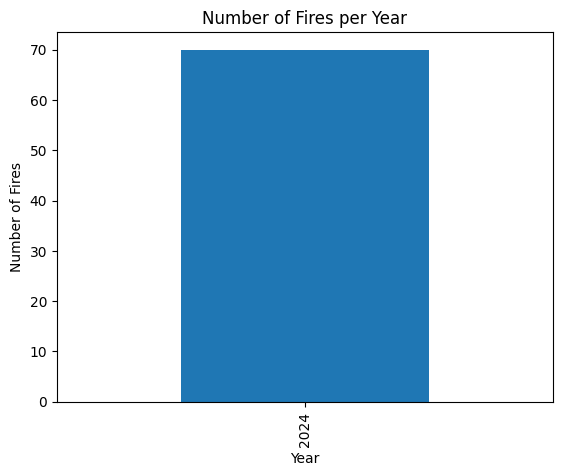

In [5]:
import matplotlib.pyplot as plt

gdf_subset['YEAR'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Fires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.show()


In [7]:
gdf_subset.head()

,ID,FIRE_CODE,FIREWEB,RES_CODE,LAND_UNIT,MONTH,YEAR,RES_CENTRE,RES_NAME,LOCAL_DESC,DATE_START,DATE_EXTIN,DATE_WITHD,REPORT_OFF,POLIC_CASE,IGNITIONCA,Yr_mnth,Area_ha,RESCODE_LU,geometry
4440,429,WATV/02/2024/20,FWATV24021901,WATV,Witzenberg Landscape Unit,2,2024,None,Voëlvlei Nature Reserve,Voelvlei NR (R43),19/02/2024,19/02/2024,19/02/2024,Thobani Mbonane,None,Mechanical - Power equipment,2024-02,11.339111,Central,"POLYGON ((19.03069 -33.33394, 19.03081 -33.333..."
4441,2412,LMBR/01/2024/15,FLMBR24011302,LMBR,Witzenberg Landscape Unit,1,2024,None,Haweqwa Nature Reserve,Groendal #2,13/01/2024,13/01/2024,14/01/2024,Patrick Shone,VB 304/01/2024,People - Children,2024-01,6.706971,Central,"POLYGON ((19.11368 -33.88448, 19.11365 -33.884..."
4442,3352,HOTT/01/2024/08,FHOTT24010701,HOTT,Boland Landscape Unit,1,2024,None,Hottentots-Holland Nature Reserve,High Noon,07/01/2024,08/01/2024,08/01/2024,Marietta Plaatjies,408/01/2024,People - Arson,2024-01,0.312010,Central,"POLYGON ((19.27651 -33.92623, 19.27652 -33.926..."
4443,3653,GRVB/01/2024/36,FGRVB24012907,GRVB,Langeberg Landscape Unit,1,2024,None,Grootvadersbosch Nature Reserve,GVB Camp site,29/01/2024,30/01/2024,30/01/2024,Dominique Coetzee,OB 5/02/2024,People - Other,2024-01,0.048449,South,"POLYGON ((20.82201 -33.98555, 20.82209 -33.985..."
4444,1929,LMBR/04/2024/24,FLMBR24042301,LMBR,Witzenberg Landscape Unit,4,2024,None,Haweqwa Nature Reserve,Seven Hills prescribed burn,23/04/2024,23/04/2024,26/04/2024,Patrick Shone,None,Fire operations - Block burns,2024-04,8.639328,Central,"MULTIPOLYGON (((19.07727 -33.66347, 19.07726 -..."
